In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
from pixell import reproject
from classy import Class
%matplotlib inline
import s1 
import ST

NameError: name 'r' is not defined

In [34]:
def compS3 ( i2  , mor_l, jmax , nside , gaus_l = None , lmax = None , resol = None):

    if lmax == None :
        lmax = 3 * nside 
        
    if resol==None :
        resol = hp.nside2resol(nside, arcmin =False )
        
    
    S3 = np.zeros((jmax,jmax,jmax ))
    
    
    for j1 in range(jmax):
        
        for j2 in range (j1+1 , jmax):
            
            print (j1 , j2)
            I2=i2[j1][j2]
            mapalm2=hp.map2alm(I2, lmax ,use_pixel_weights=True)
            #print(mapalm2)
            for j3 in range (jmax):
                    
                sigma3 = (0.8*resol*2**j3)
                freq3 =(3.0*np.pi) /(4.0*resol*2**j3)
            
                #filter 3       
                f3=mor_l[j3]
                print(f3)
                #Convolving I2 with filter 3
                
                nalm3 = hp.almxfl (mapalm2 , f3)
                I3 = hp.alm2map(nalm3 , nside , lmax)
                
                #modulus
                I3=np.abs(I3)
                
                
                if gaus_l == None:
            
                    S3map = I3
            
                else:

                    #Gaussian filter to get S2
                    gausl3 = gaus_l[j3]
                
                    #Convolving with gaussian filter to get S3
                    I3alm = hp.map2alm (I3 , lmax , use_pixel_weights=True)
                    nI3alm = hp.almxfl(I3alm , gausl3 )
                    S3map = hp.alm2map(nI3alm, nside,lmax)     
                           
            #averaging the entire map
            S3[j1 , j2 , j3] = np.mean(S3map)
    
    return S3 

In [2]:
res2048_arcmin = hp.nside2resol(2048, arcmin=True)
res1024_arcmin = hp.nside2resol(1024, arcmin=True)
res512_arcmin = hp.nside2resol(512, arcmin=True)
res256_arcmin = hp.nside2resol(256, arcmin=True)
res2048 = hp.nside2resol(2048, arcmin=False)
res1024 = hp.nside2resol(1024, arcmin=False)
res512 = hp.nside2resol(512, arcmin=False)
res256 = hp.nside2resol(256, arcmin=False)

In [3]:
cmap = plt.cm.RdBu

In [4]:
c__256 = 'C0'
c__512 = 'C1'
c_1024 = 'C2'
c_proj = 'C2'
c_fgen = 'C3'

<font size="5">Scattering Transform</font>

Implementing the transform.

Wavelet description:

$\sigma = 0.8 \times 2^j$

$k = \frac{3\pi}{4 \times 2^j}$

Transform steps

Map = $I_0$

$\psi_1$ = set of filters corresponding to $j_1$

$\psi_2$ = set of filters corresponding to $j_2$

$\phi_1$ = Gaussian filter correspoding to $j_1$

$\phi_2$ = Gaussian filter correspoding to $j_2$

1. $I_1 = |I_0 \star \psi_1|$
2. $S_1 = \langle I_1 \star \phi_1 \rangle$
3. $I_2 = |I_1 \star \psi_2|$
4. $S_2 = \langle I_2 \star \phi_2 \rangle$


In [83]:
jmax = 10
resol = res1024
theta_bin = 10000
lmax = 10000
morl = s1.morlet_arr(resol, jmax, lmax, theta_bin)
    

#plt.xlim(0,6000)

/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1242: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1243: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1247: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


(0.0, 10000.0)

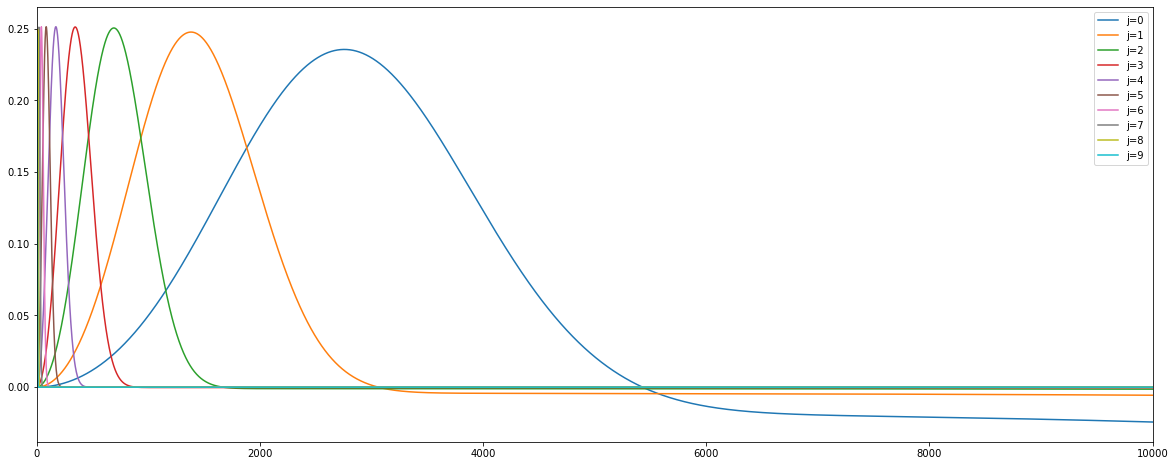

In [84]:

ell = np.arange (lmax+1)
fig=plt.figure(figsize=[20,8])
for j in range(jmax):
    plt.plot(ell,morl[j],label='j='+str(j))
    plt.legend()
    

plt.xlim (0,10000)

# SZ Map

In [2]:
map_sz = hp.read_map ("/Users/arefe/Projects/ScatteringTransform/maps/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits")

In [184]:
#map_sz = hp.read_map ("/Users/arefe/Projects/ScatteringTransform/maps/COM_CompMap_SZ-commander_0256_R2.00.fits")

In [3]:
map_sz_0256 = hp.ud_grade(map_sz , nside_out=256)

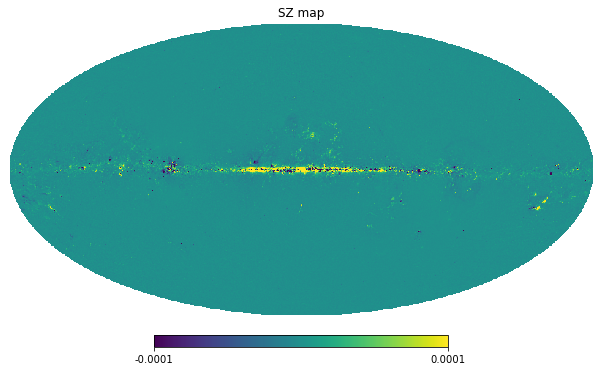

In [13]:
#vmax = max(abs(map_sz_256.min()), abs(map_sz_256.max()))

hp.mollview(map_sz, min =-0.0001,max= 0.0001  ,title="SZ map")


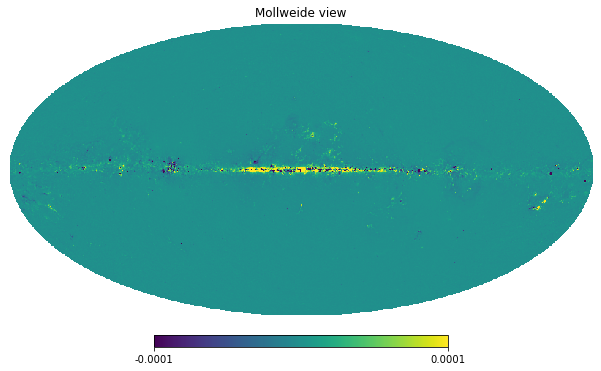

In [9]:
hp.mollview(map_sz_0256 , min =-0.0001,max= 0.0001)

In [4]:
nside_0256 = hp.pixelfunc.get_nside(map_sz_0256)
print (nside_0256)

256


In [27]:
cl_sz = hp.anafast(map_sz)

In [5]:
cl_sz_0256 = hp.anafast(map_sz_0256)

In [28]:
lmax=np.shape(cl_sz)[0]
ell=np.arange(0,lmax)
norm = ell * (ell+1) / (2*np.pi)
dl_sz = cl_sz * norm

In [6]:
lmax_0256=np.shape(cl_sz_0256)[0]
ell_0256=np.arange(0,lmax_0256)
norm_0256 = ell_0256 * (ell_0256+1) / (2*np.pi)
dl_sz_0256 = cl_sz_0256*norm_0256

<ipython-input-7-a69032c6eb21>:1: RuntimeWarning: divide by zero encountered in true_divide
  ellsc_0256 = 360*60/ell_0256
<ipython-input-7-a69032c6eb21>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(ellsc_0256,np.log(dl_sz_0256))


Text(0, 0.5, '$D_l$')

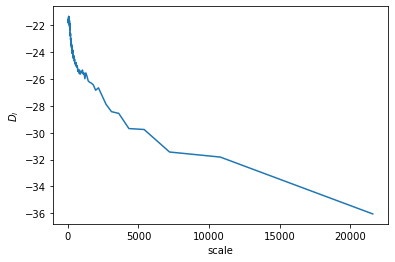

In [7]:
ellsc_0256 = 360*60/ell_0256
#ellsc = ellsc[::-1]
plt.plot(ellsc_0256,np.log(dl_sz_0256))
plt.xlabel("scale")
plt.ylabel("$D_l$")

<ipython-input-36-3065c00bde98>:1: RuntimeWarning: divide by zero encountered in true_divide
  ellsc = 360*60/ell
<ipython-input-36-3065c00bde98>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(ellsc,np.log(dl_sz))


Text(0, 0.5, '$D_l$')

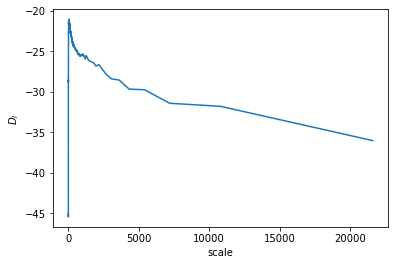

In [36]:
ellsc = 360*60/ell
#ellsc = ellsc[::-1]
plt.plot(ellsc,np.log(dl_sz))
plt.xlabel("scale")
plt.ylabel("$D_l$")


In [48]:
nside = 2048
resol = hp.nside2resol(2048 , arcmin=False)

In [11]:
resol_0256 = hp.nside2resol(nside_0256 , arcmin = False )
resol_0256_arcmin = hp.nside2resol(nside_0256 , arcmin=True)

In [12]:
jmax = 10 
theta_bin = 10000

In [13]:
Jf=np.arange(jmax)
scale_0256=2**Jf*((2*res256_arcmin)/0.75)

In [49]:
mor_l = s1.morlet_arr (resol, jmax , lmax, theta_bin)
gaus_l = s1.gaus_arr (resol, jmax, lmax, theta_bin)

In [14]:
mor_l_0256 = s1.morlet_arr (resol_0256, jmax , lmax_0256, theta_bin)
gaus_l_0256 = s1.gaus_arr (resol_0256, jmax, lmax_0256, theta_bin)

/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1242: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1243: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1247: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


In [16]:
%%time 
s1_sz , i1_sz = s1.compS1 (map_sz , mor_l, gaus_l , resol, jmax, lmax , nside )

NameError: name 'mor_l' is not defined

In [15]:
%%time 
s1_sz_0256 , i1_sz_0256 = s1.compS1 (map_sz_0256 , mor_l_0256, gaus_l_0256 , resol_0256, jmax, lmax_0256 , nside_0256 )

0
1
2
3
4
5
6
7
8
9
CPU times: user 6.87 s, sys: 160 ms, total: 7.03 s
Wall time: 1.96 s


In [16]:
%%time 
s1_sz_0256_nofilt , i1_sz_0256_nofilt = ST.compS1 (map_sz_0256 , mor_l= mor_l_0256 ,jmax= jmax, nside=nside_0256 )

0
1
2
3
4
5
6
7
8
9
CPU times: user 2.32 s, sys: 56.2 ms, total: 2.38 s
Wall time: 668 ms


Text(0, 0.5, 'log(S1)')

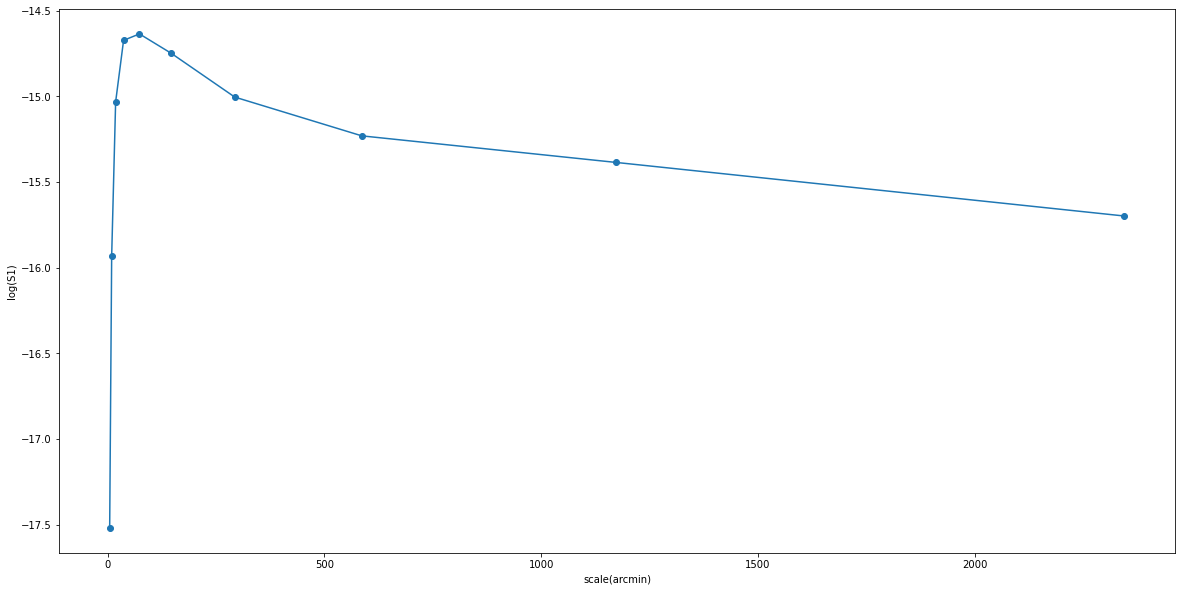

In [16]:
Jf=np.arange(jmax)
scale=2**Jf*((2*res2048_arcmin)/0.75)

plt.figure(figsize=(20,10))
plt.plot (scale,np.log(s1_sz),'o-')
plt.xlabel("scale(arcmin)")
plt.ylabel("log(S1)")

In [51]:
map_sz_out = hp.synfast (cl_sz,nside)

In [15]:
map_sz_0256_out = hp.synfast (cl_sz_0256,nside_0256)

In [16]:
cl_sz_0256_out = hp.anafast (map_sz_0256_out)
dl_sz_0256_out = cl_sz_0256_out*norm_0256
dl_sz_0256 = cl_sz_0256*norm_0256

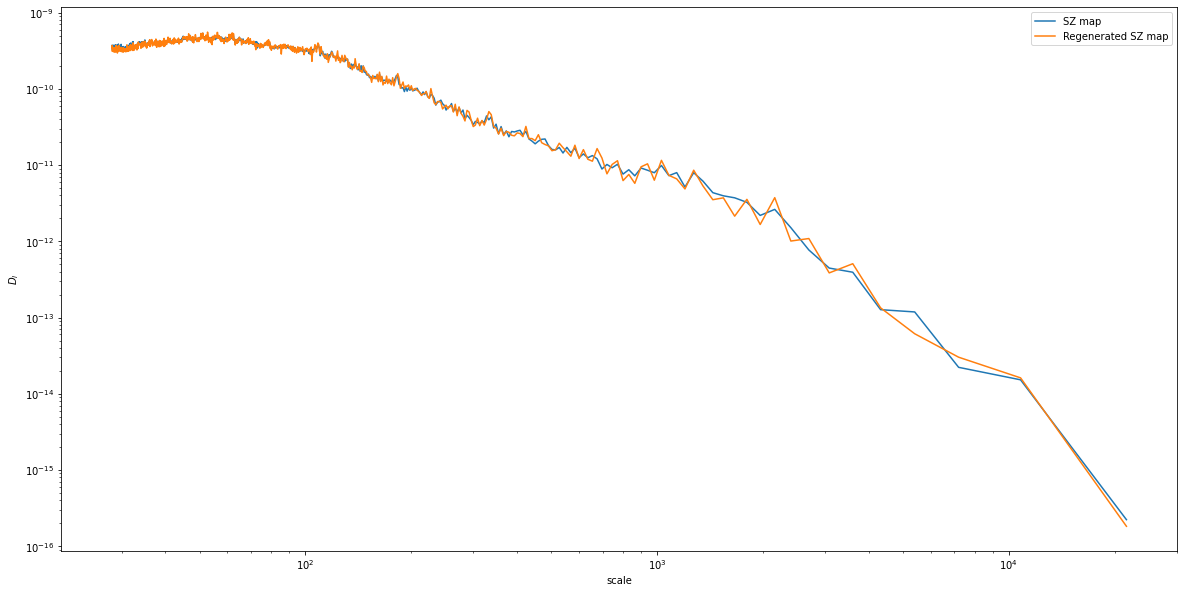

In [17]:
fig = plt.figure (figsize = (20,10))
plt.loglog(ellsc_0256,dl_sz_0256)
plt.loglog(ellsc_0256 , dl_sz_0256_out)
plt.xlabel("scale")
plt.ylabel("$D_l$")
plt.legend (["SZ map" , "Regenerated SZ map"])


In [ ]:
s1_sz_out , i1_sz_out = s1.compS1 (map_sz_out, mor_l, gaus_l, resol, jmax, lmax , nside )

0
1
2
3
4
5
6
7


In [37]:
s1_sz_0256_out , i1_sz_0256_out = s1.compS1 (map_sz_0256_out, mor_l_0256, gaus_l_0256, resol_0256, jmax, lmax_0256 , nside_0256 )

0
1
2
3
4
5
6
7
8
9


<ipython-input-39-c348b489fbdf>:6: RuntimeWarning: divide by zero encountered in log
  plt.plot (ellsc_0256 , np.log (dl_sz_0256))


Text(0, 0.5, '$log(Sl)$')

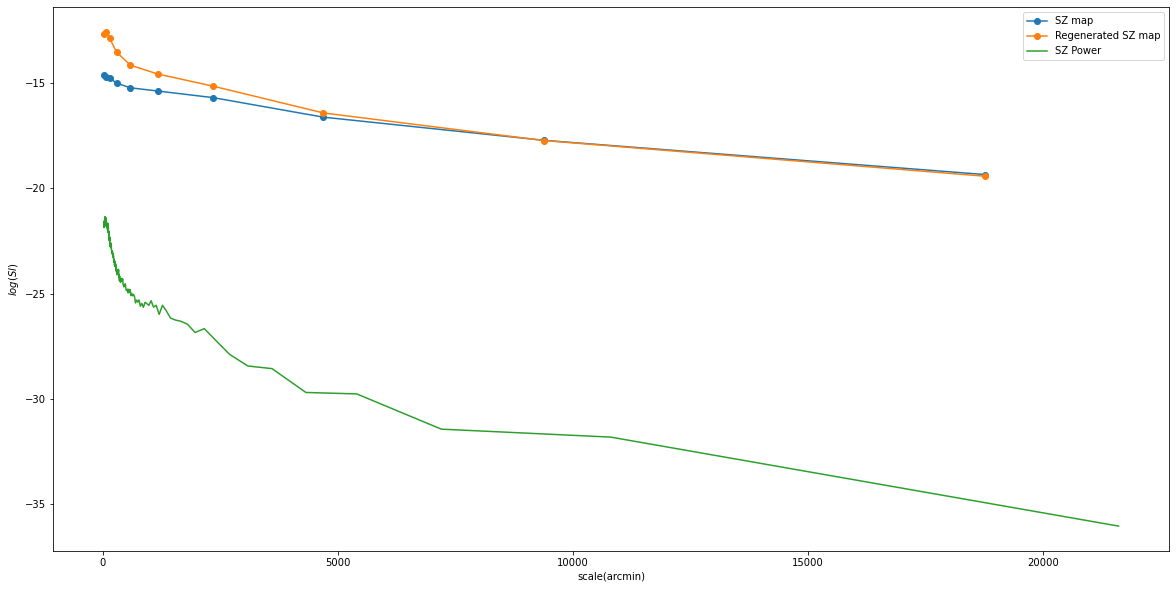

In [39]:
plt.figure(figsize=(20,10))
#plt.plot (scale,s1_sz,'o-')
#plt.plot (scale,s1_sz_out,'o-')
plt.plot (scale_0256,np.log(s1_sz_0256),'o-')
plt.plot(scale_0256,np.log(s1_sz_0256_out),'o-')
plt.plot (ellsc_0256 , np.log (dl_sz_0256))
plt.legend(["SZ map", "Regenerated SZ map","SZ Power"])
plt.xlabel("scale(arcmin)")
plt.ylabel("$log(Sl)$")

Text(0, 0.5, '$log(Sl)$')

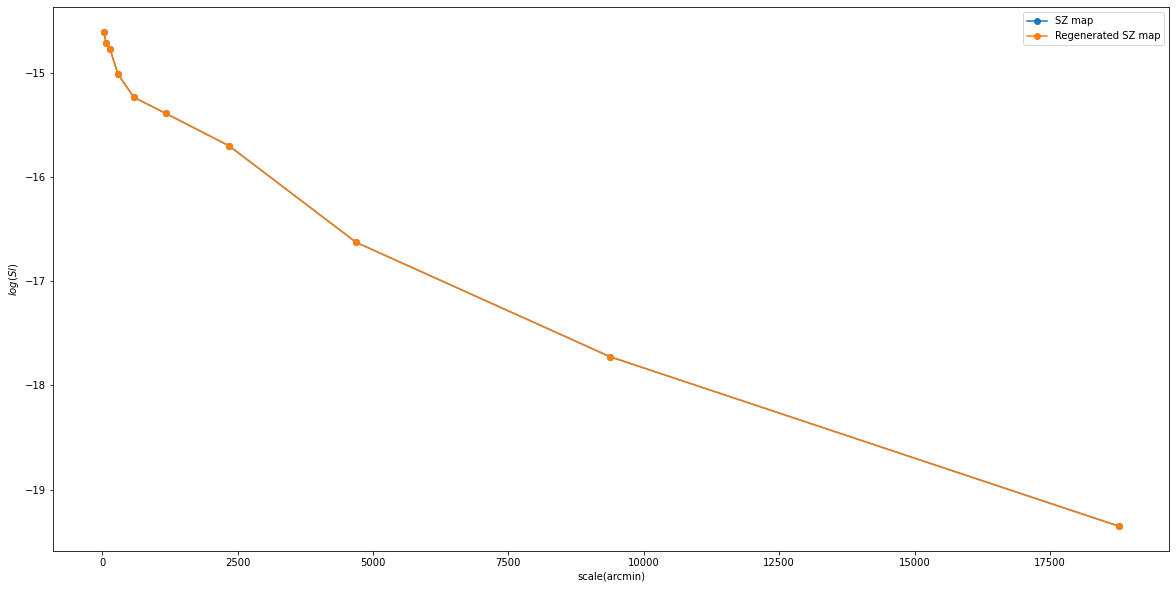

In [18]:
plt.figure(figsize=(20,10))
#plt.plot (scale,s1_sz,'o-')
#plt.plot (scale,s1_sz_out,'o-')
plt.plot (scale_0256,np.log(s1_sz_0256),'o-')
plt.plot(scale_0256,np.log(s1_sz_0256_nofilt),'o-')
#plt.plot (ellsc , np.log (dl_sz))
plt.legend(["SZ map", "Regenerated SZ map"])
plt.xlabel("scale(arcmin)")
plt.ylabel("$log(Sl)$")

Text(0, 0.5, '$Sl$')

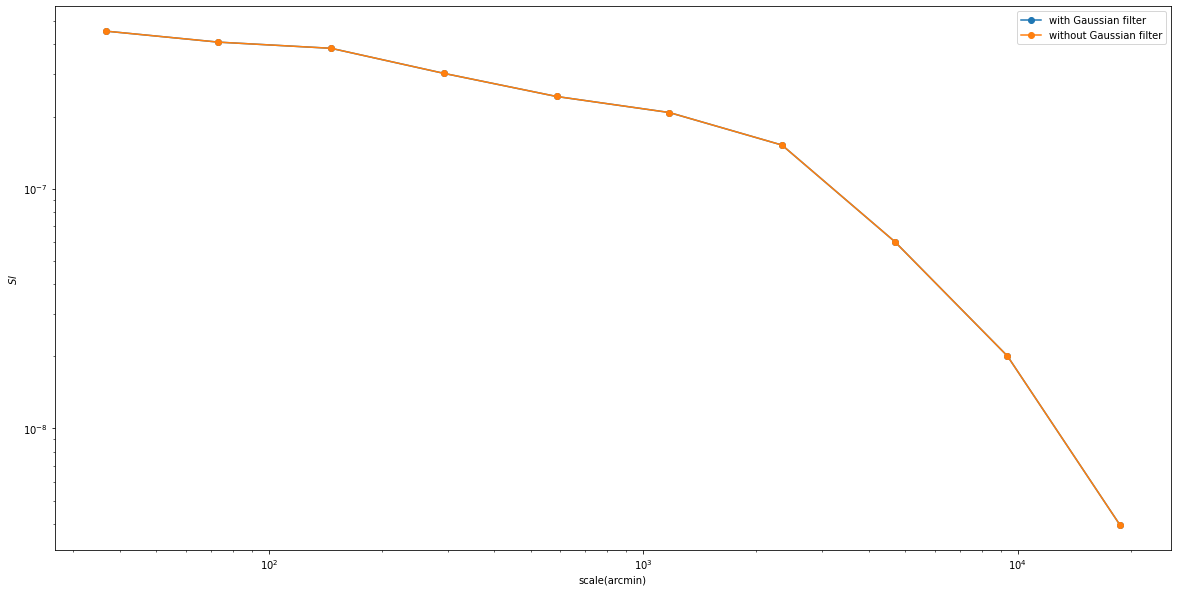

In [21]:
plt.figure(figsize=(20,10))
#plt.plot (scale,s1_sz,'o-')
#plt.plot (scale,s1_sz_out,'o-')
plt.loglog (scale_0256,s1_sz_0256,'o-')
plt.loglog(scale_0256,s1_sz_0256_nofilt,'o-')
plt.legend(["with Gaussian filter", "without Gaussian filter"])
plt.xlabel("scale(arcmin)")
plt.ylabel("$Sl$")

Text(0, 0.5, '$Sl$')

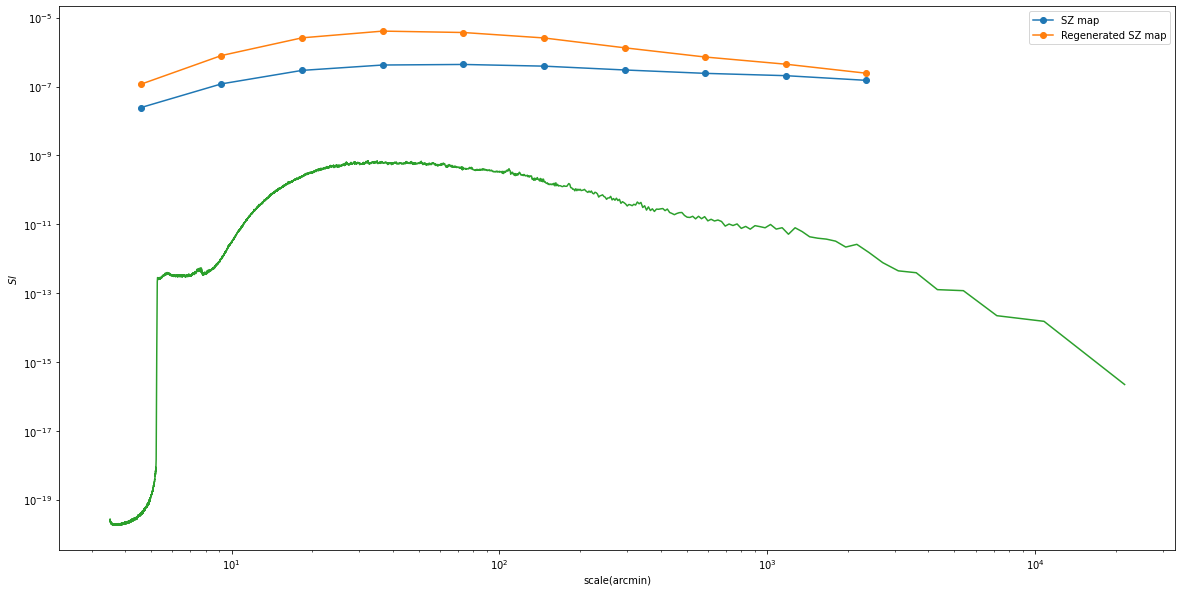

In [108]:
plt.figure(figsize=(20,10))
#plt.plot (scale,s1_sz,'o-')
#plt.plot (scale,s1_sz_out,'o-')
plt.loglog (scale,s1_sz,'o-')
plt.loglog(scale,s1_sz_out,'o-')
plt.loglog(ellsc , dl_sz)
plt.legend(["SZ map", "Regenerated SZ map" , ""])
plt.xlabel("scale(arcmin)")
plt.ylabel("$Sl$")

Text(0, 0.5, '$Sl$')

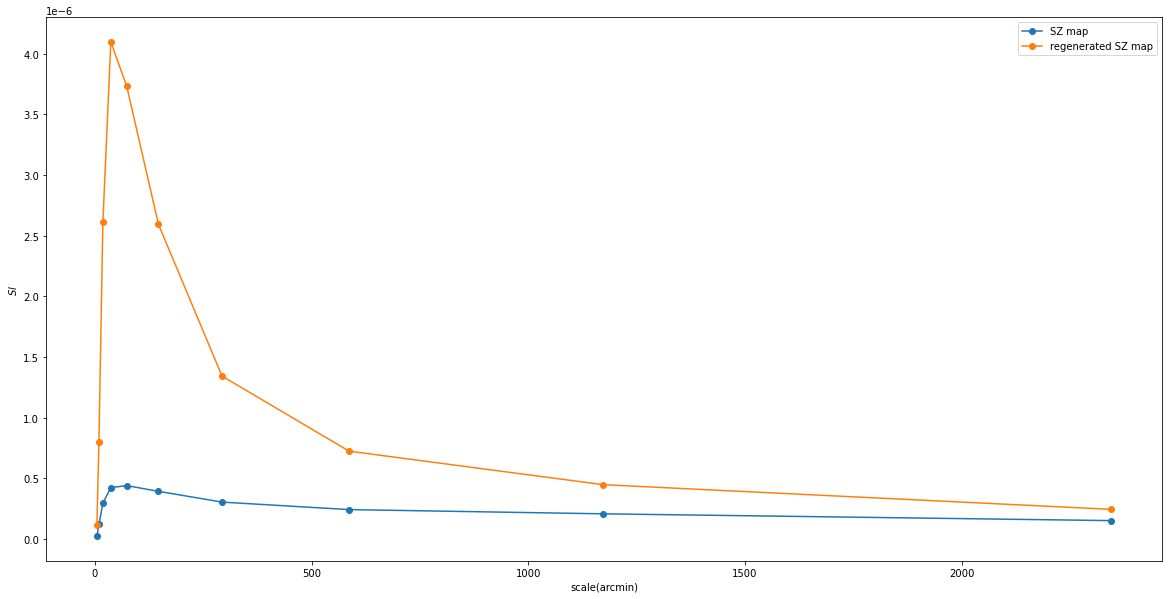

In [93]:
Jf=np.arange(jmax)
scale=2**Jf*((2*res2048_arcmin)/0.75)

plt.figure(figsize=(20,10))
plt.plot (scale,s1_sz,'o-')
plt.plot (scale,s1_sz_out,'o-')
#plt.plot (scale,np.log(s1_sz_out_alm),'o-')
#plt.plot(ellsc,np.log(dl_sz))
plt.legend(["SZ map", "Regenerated SZ map"])
plt.xlabel("scale(arcmin)")
plt.ylabel("$Sl$")

In [24]:
Jf=np.arange(jmax)
scale_0256=2**Jf*((2*resol_0256_arcmin)/0.75)

plt.figure(figsize=(20,10))
plt.loglog (scale,s1_sz,'o-')
plt.loglog (scale,s1_sz_out,'o-')
plt.loglog (scale,s1_sz_0256,'o-')
plt.loglog (scale,s1_sz_0256_out,'o-')
#plt.loglog(ellsc , dl_sz)
#plt.plot (scale,np.log(s1_sz_out_alm),'o-')
#plt.plot(ellsc,np.log(dl_sz))
plt.legend(["SZ map nside=2048", "Regenerated SZ map nside=2048" ,"SZ map nside=256", "Regenerated SZ map nside=256"])
plt.xlabel("scale(arcmin)")
plt.ylabel("$Sl$")

NameError: name 'scale' is not defined

<Figure size 1440x720 with 0 Axes>

In [21]:
%%time 
s2_sz  = s1.compS2 (map_sz , i1_sz, mor_l, gaus_l , resol_sz, jmax, lmax , nside )

0
1
2
3
4
5
6
7
8
9
CPU times: user 6h 3min 22s, sys: 6min 59s, total: 6h 10min 22s
Wall time: 3h 45min 24s


In [18]:
%%time 
s2_sz_0256  = s1.compS2 (map_sz_0256 , i1_sz_0256, mor_l_0256, gaus_l_0256 , resol_0256, jmax, lmax_0256 , nside_0256 )

0
1
2
3
4
5
6
7
8
9
CPU times: user 1min 8s, sys: 1.49 s, total: 1min 9s
Wall time: 20.3 s


In [17]:
%%time 
s2_sz_0256_nofilt  , i2_sz_0256_nofilt   = ST.compS2 ( i1_sz_0256_nofilt, mor_l_0256,  jmax, nside_0256 )

0
1
2
3
4
5
6
7
8
9
CPU times: user 22.8 s, sys: 568 ms, total: 23.4 s
Wall time: 6.81 s


In [35]:
s3_sz_0256 = compS3 (i2_sz_0256_nofilt , mor_l_0256 , jmax , nside_0256  )

0 1
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

0 3
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

0 6
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

0 9
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

1 3
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

1 7
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

2 3
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

2 9
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

3 6
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

3 7
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

3 8
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

3 9
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

4 7
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

5 6
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

5 9
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

6 7
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

7 8
[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.1

[-2.59778060e-17  2.63079692e-05  7.89317266e-05  1.57886883e-04
  2.63196788e-04  3.94892446e-04  5.53012413e-04  7.37602658e-04
  9.48716404e-04  1.18641394e-03  1.45076241e-03  1.74183558e-03
  2.05971355e-03  2.40448251e-03  2.77623440e-03  3.17506655e-03
  3.60108139e-03  4.05438600e-03  4.53509176e-03  5.04331389e-03
  5.57917103e-03  6.14278477e-03  6.73427917e-03  7.35378025e-03
  8.00141549e-03  8.67731330e-03  9.38160246e-03  1.01144115e-02
  1.08758684e-02  1.16660995e-02  1.24852294e-02  1.33333801e-02
  1.42106704e-02  1.51172153e-02  1.60531255e-02  1.70185065e-02
  1.80134581e-02  1.90380738e-02  2.00924402e-02  2.11766360e-02
  2.22907320e-02  2.34347897e-02  2.46088611e-02  2.58129881e-02
  2.70472017e-02  2.83115214e-02  2.96059546e-02  3.09304958e-02
  3.22851265e-02  3.36698140e-02  3.50845112e-02  3.65291558e-02
  3.80036701e-02  3.95079600e-02  4.10419148e-02  4.26054065e-02
  4.41982894e-02  4.58203997e-02  4.74715548e-02  4.91515533e-02
  5.08601739e-02  5.25971

[-7.72910707e-17  1.70035490e-03  5.13014751e-03  1.03408172e-02
  1.73934490e-02  2.63414843e-02  3.72107810e-02  4.99792729e-02
  6.45585685e-02  8.07796824e-02  9.83847178e-02  1.17025759e-01
  1.36271541e-01  1.55621735e-01  1.74527920e-01  1.92419735e-01
  2.08734158e-01  2.22945618e-01  2.34594561e-01  2.43312265e-01
  2.48840030e-01  2.51041434e-01  2.49906910e-01  2.45550587e-01
  2.38199945e-01  2.28179393e-01  2.15889245e-01  2.01781863e-01
  1.86336770e-01  1.70036482e-01  1.53344563e-01  1.36687087e-01
  1.20438304e-01  1.04910907e-01  9.03508879e-02  7.69366667e-02
  6.47819019e-02  5.39412230e-02  4.44180479e-02  3.61736413e-02
  2.91366394e-02  2.32123779e-02  1.82915055e-02  1.42575200e-02
  1.09930134e-02  8.38455021e-03  6.32620889e-03  4.72190167e-03
  3.48664013e-03  2.54694207e-03  1.84058135e-03  1.31587162e-03
  9.30653124e-04  6.51123600e-04  4.50623578e-04  3.08456858e-04
  2.08800240e-04  1.39734204e-04  9.24085653e-05  6.03441388e-05
  3.88626054e-05  2.46314

[-4.07031529e-17  1.20182102e-01  2.25092928e-01  1.83220076e-01
  7.46872558e-02  1.56814029e-02  1.69361662e-03  1.01077874e-04
 -2.06918954e-06  3.95229948e-06 -3.20666358e-06  2.58546083e-06
 -2.14525516e-06  1.74298699e-06 -1.47726472e-06  1.21131130e-06
 -1.05143929e-06  8.67730768e-07 -7.72035749e-07  6.38717544e-07
 -5.82872895e-07  4.81309376e-07 -4.50962527e-07  3.70027198e-07
 -3.56490882e-07  2.89350962e-07 -2.87211428e-07  2.29546507e-07
 -2.35331729e-07  1.84332752e-07 -1.95755378e-07  1.49548311e-07
 -1.65063905e-07  1.22368813e-07 -1.40910993e-07  1.00834903e-07
 -1.21652297e-07  8.35600799e-08 -1.06113470e-07  6.95454204e-08
 -9.34413334e-08  5.80593890e-08 -8.30063177e-08  4.85582423e-08
 -7.43372102e-08  4.06322967e-08 -6.70767142e-08  3.39690146e-08
 -6.09506629e-08  2.83272296e-08 -5.57463593e-08  2.35188791e-08
 -5.12971178e-08  1.93958784e-08 -4.74710824e-08  1.58405670e-08
 -4.41630400e-08  1.27586726e-08 -4.12883569e-08  1.00740714e-08
 -3.87784389e-08  7.72484

[-9.53714042e-18  1.63421735e-06  4.90268294e-06  9.80545853e-06
  1.63426367e-05  2.45143411e-05  3.43207258e-05  4.57619760e-05
  5.88383076e-05  7.35499669e-05  8.98972313e-05  1.07880409e-04
  1.27499837e-04  1.48755885e-04  1.71648952e-04  1.96179467e-04
  2.22347890e-04  2.50154711e-04  2.79600449e-04  3.10685653e-04
  3.43410904e-04  3.77776809e-04  4.13784008e-04  4.51433168e-04
  4.90724986e-04  5.31660188e-04  5.74239529e-04  6.18463793e-04
  6.64333792e-04  7.11850367e-04  7.61014387e-04  8.11826748e-04
  8.64288375e-04  9.18400221e-04  9.74163266e-04  1.03157852e-03
  1.09064701e-03  1.15136979e-03  1.21374797e-03  1.27778265e-03
  1.34347497e-03  1.41082609e-03  1.47983721e-03  1.55050955e-03
  1.62284433e-03  1.69684284e-03  1.77250636e-03  1.84983620e-03
  1.92883371e-03  2.00950024e-03  2.09183718e-03  2.17584594e-03
  2.26152794e-03  2.34888465e-03  2.43791754e-03  2.52862809e-03
  2.62101784e-03  2.71508832e-03  2.81084109e-03  2.90827773e-03
  3.00739984e-03  3.10820

[-5.91070303e-17  1.05311572e-04  3.16059208e-04  6.32490157e-04
  1.05497099e-03  1.58398246e-03  2.22011270e-03  2.96404884e-03
  3.81656704e-03  4.77852103e-03  5.85082933e-03  7.03446104e-03
  8.33042048e-03  9.73973074e-03  1.12634162e-02  1.29024842e-02
  1.46579059e-02  1.65305966e-02  1.85213957e-02  2.06310460e-02
  2.28601734e-02  2.52092657e-02  2.76786524e-02  3.02684843e-02
  3.29787133e-02  3.58090737e-02  3.87590629e-02  4.18279238e-02
  4.50146282e-02  4.83178607e-02  5.17360045e-02  5.52671280e-02
  5.89089732e-02  6.26589456e-02  6.65141056e-02  7.04711614e-02
  7.45264645e-02  7.86760062e-02  8.29154163e-02  8.72399638e-02
  9.16445595e-02  9.61237607e-02  1.00671777e-01  1.05282481e-01
  1.09949415e-01  1.14665806e-01  1.19424580e-01  1.24218376e-01
  1.29039568e-01  1.33880277e-01  1.38732399e-01  1.43587624e-01
  1.48437459e-01  1.53273258e-01  1.58086239e-01  1.62867521e-01
  1.67608145e-01  1.72299107e-01  1.76931383e-01  1.81495964e-01
  1.85983880e-01  1.90386

[ 2.98193517e-17  6.98167389e-03  2.12778740e-02  4.31898634e-02
  7.24173308e-02  1.07536944e-01  1.45776892e-01  1.83229222e-01
  2.15479370e-01  2.38477253e-01  2.49386212e-01  2.47155653e-01
  2.32661536e-01  2.08403040e-01  1.77877483e-01  1.44832969e-01
  1.12600924e-01  8.36505939e-02  5.94174450e-02  4.03733196e-02
  2.62536440e-02  1.63435749e-02  9.74291061e-03  5.56307332e-03
  3.04303194e-03  1.59487543e-03  8.00970782e-04  3.85463645e-04
  1.77732208e-04  7.84772346e-05  3.31345784e-05  1.33230909e-05
  5.04154845e-06  1.72871344e-06  4.60249209e-07 -4.72562188e-09
 -1.67927823e-07 -2.22784782e-07 -2.40445289e-07 -2.45891463e-07
 -2.47500425e-07 -2.47955858e-07 -2.48079405e-07 -2.48111550e-07
 -2.48119596e-07 -2.48121558e-07 -2.48122050e-07 -2.48122204e-07
 -2.48122283e-07 -2.48122347e-07 -2.48122409e-07 -2.48122471e-07
 -2.48122535e-07 -2.48122600e-07 -2.48122666e-07 -2.48122733e-07
 -2.48122802e-07 -2.48122872e-07 -2.48122943e-07 -2.48123015e-07
 -2.48123089e-07 -2.48123

[ 3.26987672e-17  1.47626907e-01  5.43026342e-02 -1.39290015e-03
  1.20704310e-03 -6.39113995e-04  3.77390595e-04 -2.41358319e-04
  1.63761947e-04 -1.16271203e-04  8.55483688e-05 -6.47995765e-05
  5.02605666e-05 -3.97832606e-05  3.20237521e-05 -2.61704443e-05
  2.16540519e-05 -1.81307206e-05  1.53236942e-05 -1.30777191e-05
  1.12409173e-05 -9.74268892e-06  8.48975544e-06 -7.45284932e-06
  6.56834213e-06 -5.82856426e-06  5.18584083e-06 -4.64443775e-06
  4.16571477e-06 -3.76085079e-06  3.39654816e-06 -3.08815317e-06
  2.80564688e-06 -2.56697593e-06  2.34419923e-06 -2.15693547e-06
  1.97859799e-06 -1.82990943e-06  1.68518814e-06 -1.56590291e-06
  1.44699038e-06 -1.35043427e-06  1.25160206e-06 -1.17283957e-06
  1.08981992e-06 -1.02514790e-06  9.54716949e-07 -9.01319993e-07
  8.41011621e-07 -7.96723341e-07  7.44629234e-07 -7.07764202e-07
  6.62392016e-07 -6.31625644e-07  5.91796945e-07 -5.66078470e-07
  5.30854311e-07 -5.09342962e-07  4.77968972e-07 -4.59986590e-07
  4.31851987e-07 -4.16847

[-2.72482184e-17  6.56841769e-06  1.97057433e-05  3.94129567e-05
  6.56915268e-05  9.85434102e-05  1.37971049e-04  1.83977370e-04
  2.36565781e-04  2.95740168e-04  3.61504891e-04  4.33864783e-04
  5.12825143e-04  5.98391732e-04  6.90570770e-04  7.89368927e-04
  8.94793320e-04  1.00685151e-03  1.12555147e-03  1.25090164e-03
  1.38291084e-03  1.52158832e-03  1.66694372e-03  1.81898709e-03
  1.97772886e-03  2.14317982e-03  2.31535115e-03  2.49425437e-03
  2.67990135e-03  2.87230429e-03  3.07147572e-03  3.27742849e-03
  3.49017572e-03  3.70973084e-03  3.93610756e-03  4.16931983e-03
  4.40938187e-03  4.65630814e-03  4.91011328e-03  5.17081219e-03
  5.43841992e-03  5.71295174e-03  5.99442304e-03  6.28284938e-03
  6.57824645e-03  6.88063006e-03  7.19001612e-03  7.50642061e-03
  7.82985959e-03  8.16034916e-03  8.49790547e-03  8.84254467e-03
  9.19428291e-03  9.55313633e-03  9.91912102e-03  1.02922530e-02
  1.06725483e-02  1.10600228e-02  1.14546921e-02  1.18565720e-02
  1.22656779e-02  1.26820

[-8.30609408e-17  4.22049276e-04  1.26810417e-03  2.54196789e-03
  4.24907460e-03  6.39617296e-03  8.99091812e-03  1.20413831e-02
  1.55555038e-02  1.95404721e-02  2.40020958e-02  2.89441414e-02
  3.43676805e-02  4.02704569e-02  4.66462950e-02  5.34845643e-02
  6.07697195e-02  6.84809287e-02  7.65918025e-02  8.50702360e-02
  9.38783679e-02  1.02972665e-01  1.12304130e-01  1.21818635e-01
  1.31457374e-01  1.41157425e-01  1.50852419e-01  1.60473295e-01
  1.69949132e-01  1.79208038e-01  1.88178084e-01  1.96788259e-01
  2.04969426e-01  2.12655269e-01  2.19783199e-01  2.26295214e-01
  2.32138687e-01  2.37267074e-01  2.41640524e-01  2.45226383e-01
  2.47999581e-01  2.49942903e-01  2.51047133e-01  2.51311073e-01
  2.50741443e-01  2.49352658e-01  2.47166502e-01  2.44211692e-01
  2.40523360e-01  2.36142440e-01  2.31115010e-01  2.25491565e-01
  2.19326257e-01  2.12676118e-01  2.05600269e-01  1.98159132e-01
  1.90413667e-01  1.82424635e-01  1.74251904e-01  1.65953802e-01
  1.57586538e-01  1.49203

[ 6.42237102e-17  3.00153323e-02  8.89666813e-02  1.63531296e-01
  2.25173000e-01  2.45913900e-01  2.18561716e-01  1.60368038e-01
  9.80069992e-02  5.01727922e-02  2.15960785e-02  7.83513453e-03
  2.39984777e-03  6.21196514e-04  1.35951039e-04  2.51328047e-05
  3.88803517e-06  4.62442745e-07 -2.79513519e-09 -5.60696563e-08
 -6.12172485e-08 -6.16371881e-08 -6.16661307e-08 -6.16678227e-08
 -6.16679127e-08 -6.16679239e-08 -6.16679318e-08 -6.16679401e-08
 -6.16679486e-08 -6.16679575e-08 -6.16679666e-08 -6.16679760e-08
 -6.16679857e-08 -6.16679958e-08 -6.16680061e-08 -6.16680168e-08
 -6.16680277e-08 -6.16680390e-08 -6.16680506e-08 -6.16680624e-08
 -6.16680746e-08 -6.16680871e-08 -6.16680999e-08 -6.16681130e-08
 -6.16681264e-08 -6.16681401e-08 -6.16681541e-08 -6.16681684e-08
 -6.16681830e-08 -6.16681979e-08 -6.16682131e-08 -6.16682286e-08
 -6.16682445e-08 -6.16682606e-08 -6.16682770e-08 -6.16682938e-08
 -6.16683108e-08 -6.16683282e-08 -6.16683458e-08 -6.16683638e-08
 -6.16683821e-08 -6.16684

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 8.9890751e-09])

<ipython-input-25-7fd7629d93ba>:4: RuntimeWarning: divide by zero encountered in log
  ax[j1,j2].plot (scale_0256,np.log(s3_sz_0256[j1 , j2,:]/s1_sz_0256_nofilt),'o-')
<ipython-input-25-7fd7629d93ba>:4: RuntimeWarning: divide by zero encountered in log
  ax[j1,j2].plot (scale_0256,np.log(s3_sz_0256[j1 , j2,:]/s1_sz_0256_nofilt),'o-')
<ipython-input-25-7fd7629d93ba>:4: RuntimeWarning: divide by zero encountered in log
  ax[j1,j2].plot (scale_0256,np.log(s3_sz_0256[j1 , j2,:]/s1_sz_0256_nofilt),'o-')
<ipython-input-25-7fd7629d93ba>:4: RuntimeWarning: divide by zero encountered in log
  ax[j1,j2].plot (scale_0256,np.log(s3_sz_0256[j1 , j2,:]/s1_sz_0256_nofilt),'o-')
<ipython-input-25-7fd7629d93ba>:4: RuntimeWarning: divide by zero encountered in log
  ax[j1,j2].plot (scale_0256,np.log(s3_sz_0256[j1 , j2,:]/s1_sz_0256_nofilt),'o-')
<ipython-input-25-7fd7629d93ba>:4: RuntimeWarning: divide by zero encountered in log
  ax[j1,j2].plot (scale_0256,np.log(s3_sz_0256[j1 , j2,:]/s1_sz_0256_nofilt

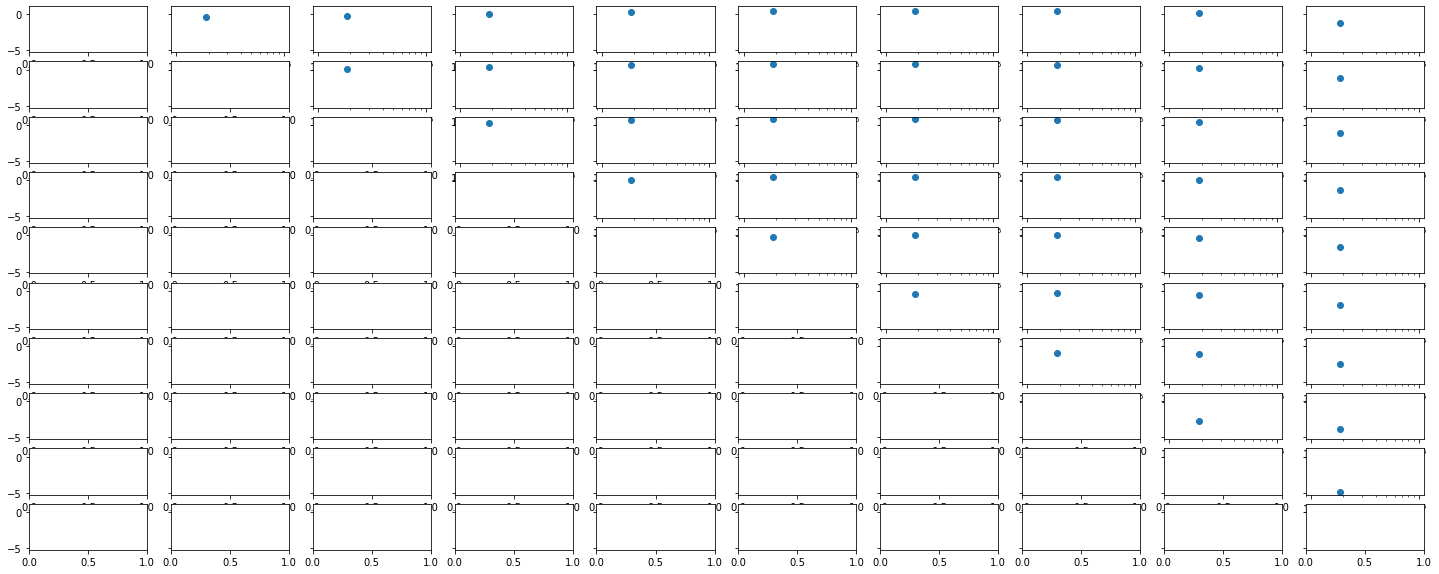

In [25]:
fig, ax = plt.subplots(jmax , jmax,sharey=True,squeeze=True,figsize=(25,10))
for j1 in range (jmax):
    for j2 in range (j1+1 , jmax ):
        ax[j1,j2].plot (scale_0256,np.log(s3_sz_0256[j1 , j2,:]/s1_sz_0256_nofilt),'o-')
        #ax[j1,j2].plot (scale_0256,np.log(s3_sz_0256_nofilt[j1,j2,:]),'o-')
        #ax[j1,j2].set_title("j1=%d"%j1)
        ax[j1,j2].set_xscale('log')
        #ax[j1,j2].legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


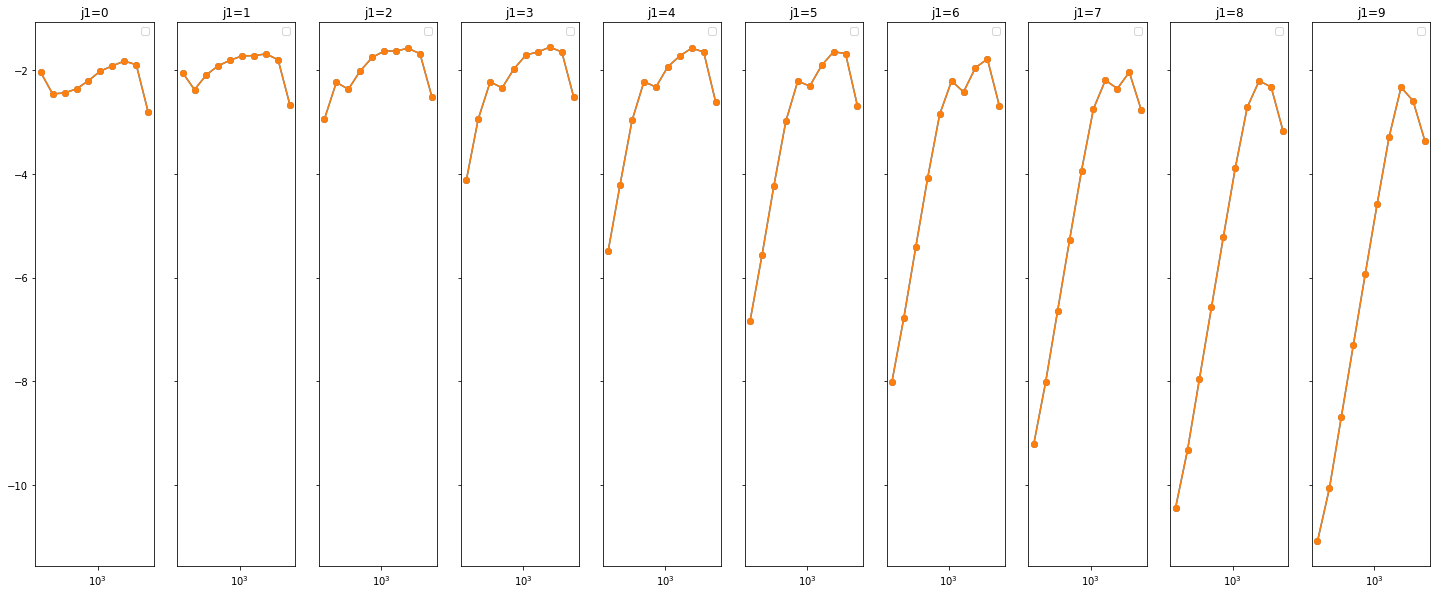

In [21]:
fig, ax = plt.subplots(1, jmax,sharey=True,squeeze=True,figsize=(25,10))
for j in range (jmax):
    ax[j].plot (scale_0256,np.log(s2_sz_0256[j,:]/s1_sz_0256[j]),'o-')
    ax[j].plot (scale_0256,np.log(s2_sz_0256_nofilt[j,:]/s1_sz_0256_nofilt[j]),'o-')
    ax[j].set_title("j1=%d"%j)
    ax[j].set_xscale('log')
    ax[j].legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


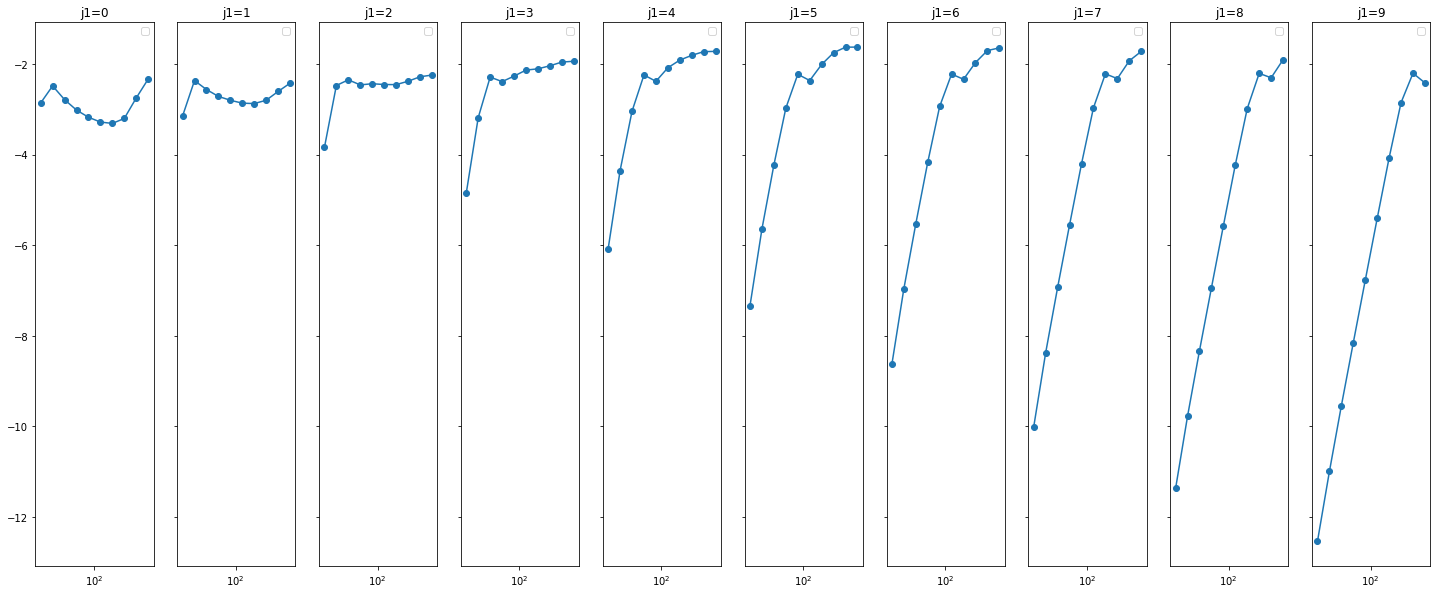

In [22]:
fig, ax = plt.subplots(1, jmax,sharey=True,squeeze=True,figsize=(25,10))
for j in range (jmax):
    ax[j].plot (scale,np.log(s2_sz[j,:]/s1_sz[j]),'o-')
    ax[j].set_title("j1=%d"%j)
    ax[j].set_xscale('log')
    ax[j].legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


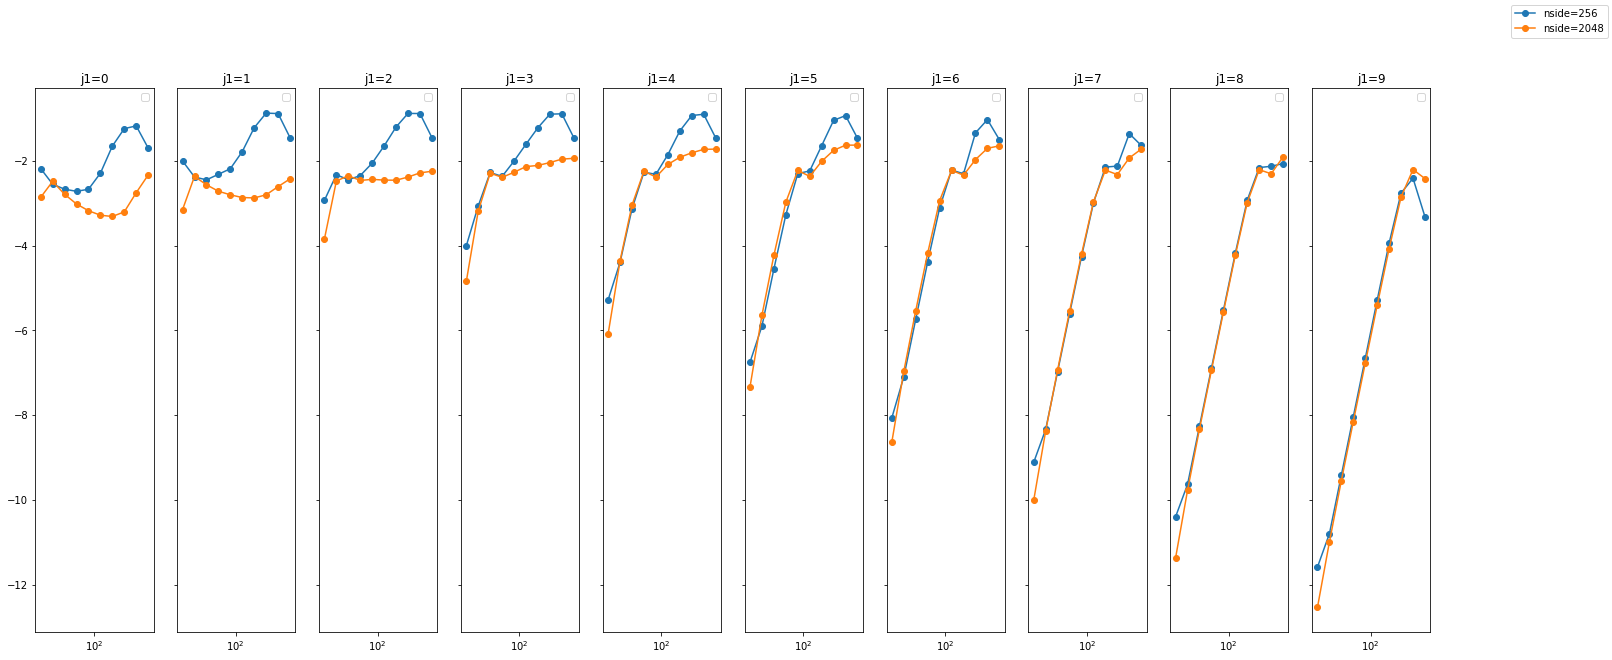

In [125]:
fig, ax = plt.subplots(1, jmax,sharey=True,squeeze=True,figsize=(25,10))
for j in range (jmax):
    ax[j].plot (scale,np.log(s2_sz_0256[j,:]/s1_sz_0256[j]),'o-')
    ax[j].plot (scale,np.log(s2_sz[j,:]/s1_sz[j]),'o-')
    ax[j].set_title("j1=%d"%j)
    ax[j].set_xscale('log')
    ax[j].legend()
fig.legend (["nside=256" ,"nside=2048"])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0.98, 'S2 coefficients for regenerated SZ maps')

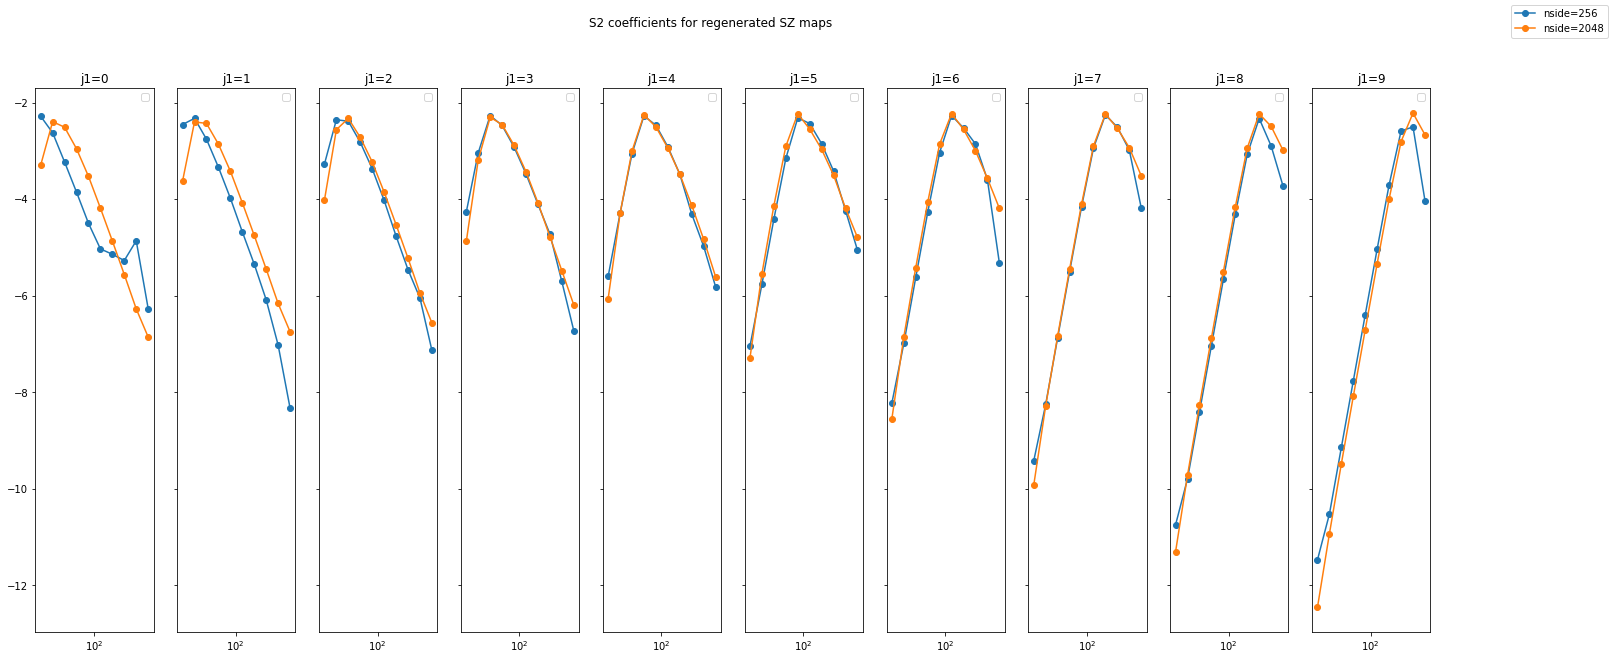

In [124]:
fig, ax = plt.subplots(1, jmax,sharey=True,squeeze=True,figsize=(25,10))
for j in range (jmax):
    ax[j].plot (scale,np.log(s2_sz_0256_out[j,:]/s1_sz_0256_out[j]),'o-')
    ax[j].plot (scale,np.log(s2_sz_out[j,:]/s1_sz_out[j]),'o-')
    ax[j].set_title("j1=%d"%j)
    ax[j].set_xscale('log')
    ax[j].legend()
fig.legend (["nside=256" , "nside=2048"])
fig.suptitle("S2 coefficients for regenerated SZ maps")

In [80]:
%%time 
s2_sz_0256_out  = s1.compS2 (map_sz_0256_out , i1_sz_0256_out, mor_l_0256, gaus_l_0256 , resol_0256, jmax, lmax_0256 , nside_0256 )

0
1
2
3
4
5
6
7
8
9
CPU times: user 1min 10s, sys: 1.38 s, total: 1min 12s
Wall time: 18.9 s


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0.98, 'S2 coefficients for SZ map nside=256')

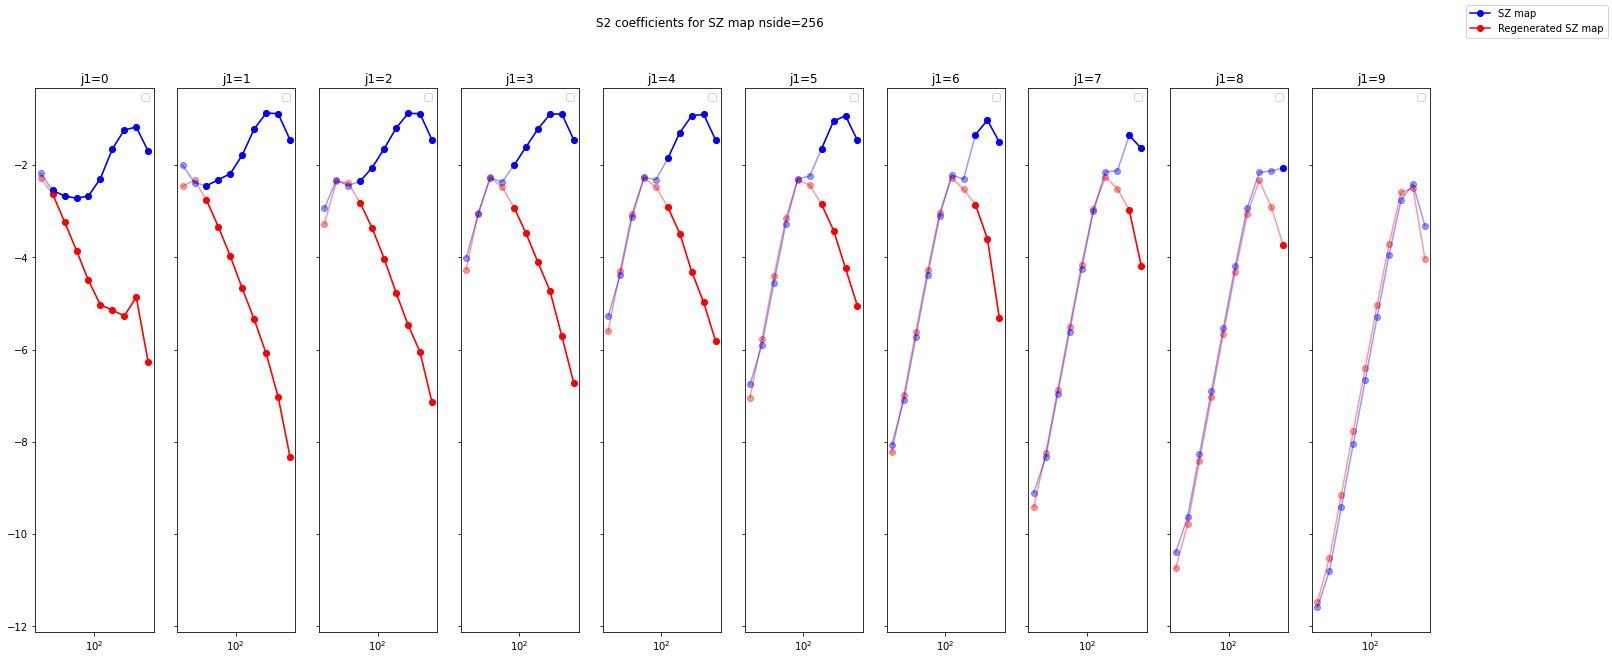

In [121]:
fig, ax = plt.subplots(1, jmax,sharey=True,squeeze=True,figsize=(25,10))
for j in range (jmax):
    ax[j].plot (scale[j+1:],np.log(s2_sz_0256[j,j+1:]/s1_sz_0256[j]),'o-' , alpha =1 , color = "blue")
    ax[j].plot (scale[j+1:],np.log(s2_sz_0256_out[j,j+1:]/s1_sz_0256_out[j]),'o-' , alpha = 1 , color = "red")
    ax[j].plot (scale,np.log(s2_sz_0256_out[j,:]/s1_sz_0256_out[j]),'o-' , alpha = 0.4 , color = "red")
    ax[j].plot (scale,np.log(s2_sz_0256[j,:]/s1_sz_0256[j]),'o-' , alpha =0.4 , color = "blue")
    ax[j].set_title("j1=%d"%j)
    ax[j].set_xscale('log')
    ax[j].legend()
fig.legend(['SZ map' ,'Regenerated SZ map'])
fig.suptitle("S2 coefficients for SZ map nside=256")

In [23]:
%%time 
s2_sz_out  = s1.compS2 (map_sz_out , i1_sz_out, mor_l, gaus_l , resol_sz, jmax, lmax , nside )

0
1
2
3
4
5
6
7
8
9
CPU times: user 6h 11min 27s, sys: 4min 50s, total: 6h 16min 17s
Wall time: 2h 37min 16s


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0.98, 'S2 coefficients for SZ map nside=2048')

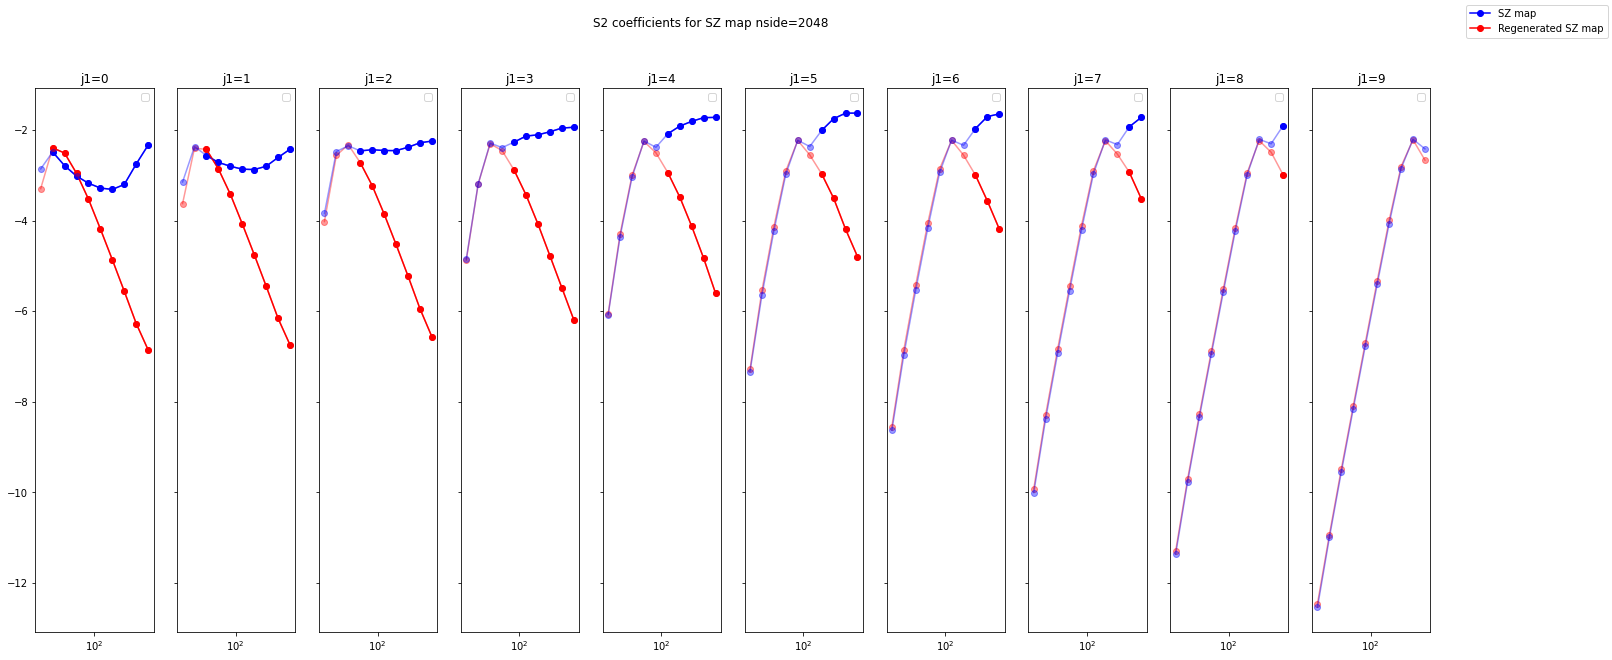

In [122]:
fig, ax = plt.subplots(1, jmax,sharey=True,squeeze=True,figsize=(25,10))
for j in range (jmax):
    ax[j].plot (scale[j+1:],np.log(s2_sz[j,j+1:]/s1_sz[j]),'o-' , alpha =1 , color = "blue")
    ax[j].plot (scale[j+1:],np.log(s2_sz_out[j,j+1:]/s1_sz_out[j]),'o-' , alpha = 1 , color = "red")
    ax[j].plot (scale,np.log(s2_sz_out[j,:]/s1_sz_out[j]),'o-' , alpha = 0.4 , color = "red")
    ax[j].plot (scale,np.log(s2_sz[j,:]/s1_sz[j]),'o-' , alpha =0.4 , color = "blue")
    ax[j].set_title("j1=%d"%j)
    ax[j].set_xscale('log')
    ax[j].legend()
fig.legend(['SZ map' ,'Regenerated SZ map'])
fig.suptitle("S2 coefficients for SZ map nside=2048")

In [135]:
alm_sz = hp.map2alm(map_sz_0256)

In [136]:
map_sz_out_alm = hp.alm2map(alm_sz , 256)

In [148]:
s1_sz_out_alm , i1_sz_out_alm = s1.compS1(map_sz_out_alm, mor_l_0256, gaus_l_0256, resol_0256, jmax, lmax_0256 , nside_0256)

0
1
2
3
4
5
6
7
8
9


In [140]:
alm_sz_out = hp.map2alm(map_sz_0256_out)

In [141]:
map_sz_out2_alm = hp.alm2map(alm_sz_out , 256)

In [149]:


s1_sz_out2_alm , i1_sz_out2_alm = s1.compS1(map_sz_out2_alm, mor_l_0256, gaus_l_0256, resol_0256, jmax, lmax_0256 , nside_0256)










0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, '$Sl$')

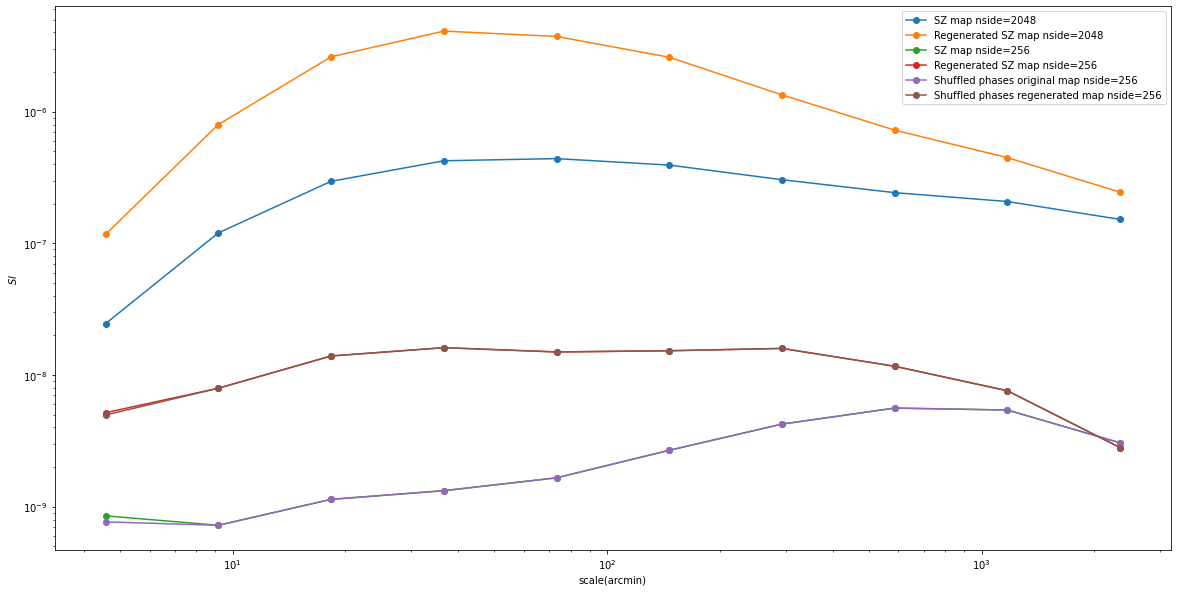

In [151]:
Jf=np.arange(jmax)
scale_0256=2**Jf*((2*resol_0256_arcmin)/0.75)

plt.figure(figsize=(20,10))
plt.loglog (scale,s1_sz,'o-')
plt.loglog (scale,s1_sz_out,'o-')
plt.loglog (scale,s1_sz_0256,'o-')
plt.loglog (scale,s1_sz_0256_out,'o-')
plt.loglog (scale,s1_sz_out_alm,'o-')
plt.loglog (scale,s1_sz_out2_alm,'o-')
#plt.loglog(ellsc , dl_sz)
#plt.plot (scale,np.log(s1_sz_out_alm),'o-')
#plt.plot(ellsc,np.log(dl_sz))
plt.legend(["SZ map nside=2048", "Regenerated SZ map nside=2048" ,"SZ map nside=256", "Regenerated SZ map nside=256" , "Shuffled phases original map nside=256" , "Shuffled phases regenerated map nside=256"])
plt.xlabel("scale(arcmin)")
plt.ylabel("$Sl$")